<a href="https://colab.research.google.com/github/Jeetkavaiya/Assignment-4_Airbnb-Price-Prediction/blob/main/Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Price Prediction: XGBoost vs Neural Networks
## EAS 510 Assignment 4

---

### Data Download from Inside Airbnb:
1. Visit: https://insideairbnb.com/get-the-data/
2. Download **listings.csv** for all 12 cities:

**Tier 1 (Big Cities):** NYC, LA, San Francisco, Chicago

**Tier 2 (Medium Cities):** Austin, Seattle, Denver, Portland

**Tier 3 (Small Cities):** Asheville, Santa Cruz, Salem, Columbus



## 1. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 2. DEFINE ALL 12 CITIES BY TIER




In [21]:
TIER1_CITIES = {
    'NYC': 'NYC.csv',
    'LA': 'LA.csv',
    'SF': 'SF.csv',
    'Chicago': 'Chicago.csv'
}

TIER2_CITIES = {
    'Austin': 'Austin.csv',
    'Seattle': 'Seattle.csv',
    'Denver': 'Denver.csv',
    'Portland': 'Portland.csv'
}

TIER3_CITIES = {
    'Asheville': 'Asheville.csv',
    'Santa_Cruz': 'SantaCruz.csv',
    'Salem': 'Salem.csv',
    'Columbus': 'Columbus.csv'
}

ALL_TIERS = {
    'Tier1_Big': TIER1_CITIES,
    'Tier2_Medium': TIER2_CITIES,
    'Tier3_Small': TIER3_CITIES
}

print("City Tiers Defined:")
for tier_name, cities in ALL_TIERS.items():
    print(f"{tier_name}: {', '.join(cities.keys())}")

City Tiers Defined:
Tier1_Big: NYC, LA, SF, Chicago
Tier2_Medium: Austin, Seattle, Denver, Portland
Tier3_Small: Asheville, Santa_Cruz, Salem, Columbus


## 3. DATA LOADING & PREPROCESSING FUNCTIONS

In [3]:
def clean_price(price_str):
    """Convert '$66.00' to 66.0"""
    if pd.isna(price_str):
        return np.nan
    if isinstance(price_str, (int, float)):
        return float(price_str)
    cleaned = re.sub(r'[$,]', '', str(price_str))
    try:
        return float(cleaned)
    except:
        return np.nan

def extract_bathroom_count(bath_value):
    """Extract numeric value from bathroom text or number"""
    if pd.isna(bath_value):
        return np.nan
    if isinstance(bath_value, (int, float)):
        return float(bath_value)
    match = re.search(r'(\d+\.?\d*)', str(bath_value))
    if match:
        return float(match.group(1))
    return np.nan

def load_and_preprocess_city(filepath, city_name):
    """Load and preprocess data for a single city"""
    try:
        df = pd.read_csv(filepath)
        df['city'] = city_name

        # Clean price
        df['price'] = df['price'].apply(clean_price)
        df = df.dropna(subset=['price'])
        df = df[(df['price'] > 20) & (df['price'] < 5000)]

        # Handle bathrooms (check both column names)
        if 'bathrooms_text' in df.columns:
            df['bathrooms_numeric'] = df['bathrooms_text'].apply(extract_bathroom_count)
        elif 'bathrooms' in df.columns:
            df['bathrooms_numeric'] = df['bathrooms'].apply(extract_bathroom_count)
        else:
            df['bathrooms_numeric'] = 1.0

        return df
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

def prepare_features(df):
    """Prepare features for modeling"""
    # Base features
    base_features = [
        'accommodates', 'bedrooms', 'beds', 'bathrooms_numeric',
        'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'number_of_reviews',
        'availability_365', 'minimum_nights', 'maximum_nights'
    ]

    # Create missing columns
    for col in base_features:
        if col not in df.columns:
            df[col] = 0
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median() if not pd.isna(df[col].median()) else 0, inplace=True)

    # Engineered features
    review_cols = [c for c in base_features if 'review_scores' in c]
    df['avg_review_score'] = df[review_cols].mean(axis=1)
    df['price_per_bedroom'] = df['price'] / (df['bedrooms'] + 1)

    if 'reviews_per_month' in df.columns:
        df['review_activity'] = pd.to_numeric(df['reviews_per_month'], errors='coerce').fillna(0)
    else:
        df['review_activity'] = df['number_of_reviews'] / (df['availability_365'] / 30 + 1)

    if 'amenities' in df.columns:
        df['amenities_count'] = df['amenities'].apply(
            lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') else 0
        )
    else:
        df['amenities_count'] = 0

    # Encode categorical
    if 'property_type' in df.columns:
        le = LabelEncoder()
        df['property_type_encoded'] = le.fit_transform(df['property_type'].fillna('Unknown'))
    else:
        df['property_type_encoded'] = 0

    if 'room_type' in df.columns:
        le = LabelEncoder()
        df['room_type_encoded'] = le.fit_transform(df['room_type'].fillna('Unknown'))
    else:
        df['room_type_encoded'] = 0

    if 'host_is_superhost' in df.columns:
        df['host_is_superhost_encoded'] = (df['host_is_superhost'] == 't').astype(int)
    else:
        df['host_is_superhost_encoded'] = 0

    # All features
    engineered = ['avg_review_score', 'price_per_bedroom', 'review_activity',
                  'amenities_count', 'property_type_encoded', 'room_type_encoded',
                  'host_is_superhost_encoded']

    all_features = base_features + engineered

    return df, all_features

print("Data processing functions defined")

Data processing functions defined


## 4. MODEL BUILDING FUNCTIONS

In [4]:
def build_xgboost():
    """Build XGBoost model"""
    return xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,
        random_state=42,
        n_jobs=-1
    )

def build_nn(n_features):
    """Build Neural Network model"""
    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    return model

def evaluate_model(y_true, y_pred):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

## 5. LOAD ALL DATA

In [5]:
print("="*70)
print("LOADING ALL CITY DATA")
print("="*70 + "\n")

# Store all city data
all_city_data = {}
tier_data = {'Tier1_Big': [], 'Tier2_Medium': [], 'Tier3_Small': []}

for tier_name, cities in ALL_TIERS.items():
    print(f"\n{tier_name}:")
    for city_name, filepath in cities.items():
        df = load_and_preprocess_city(filepath, city_name)
        if df is not None:
            df, features = prepare_features(df)
            all_city_data[city_name] = {'df': df, 'features': features, 'tier': tier_name}
            tier_data[tier_name].append(df)
            print(f"{city_name}: {len(df):,} listings")

# Combine tier data
tier_combined = {}
for tier_name, dfs in tier_data.items():
    if dfs:
        tier_combined[tier_name] = pd.concat(dfs, ignore_index=True)
        print(f"\n{tier_name} combined: {len(tier_combined[tier_name]):,} listings")

LOADING ALL CITY DATA


Tier1_Big:
NYC: 21,073 listings
LA: 36,535 listings
SF: 5,775 listings
Chicago: 7,608 listings

Tier2_Medium:
Austin: 10,598 listings
Seattle: 6,157 listings
Denver: 4,271 listings
Portland: 3,762 listings

Tier3_Small:
Asheville: 2,530 listings
Santa_Cruz: 1,545 listings
Salem: 279 listings
Columbus: 2,683 listings

Tier1_Big combined: 70,991 listings

Tier2_Medium combined: 24,788 listings

Tier3_Small combined: 7,037 listings


## 6. INDIVIDUAL CITY PERFORMANCE

In [8]:
print("="*70)
print("INDIVIDUAL CITY PERFORMANCE ANALYSIS")
print("Train XGBoost and Neural Network for EACH city separately")
print("="*70 + "\n")

individual_results = []

for city_name, city_info in all_city_data.items():
    print(f"\n{'='*50}")
    print(f"City: {city_name} ({city_info['tier']})")
    print(f"{'='*50}")

    df = city_info['df']
    features = city_info['features']

    # Prepare data
    df_clean = df.dropna(subset=features + ['price'])
    X = df_clean[features].values
    y = df_clean['price'].values

    if len(X) < 100:
        print(f"Insufficient data ({len(X)} samples). Skipping.")
        continue

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale for NN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"  Samples: {len(X):,} | Train: {len(X_train):,} | Test: {len(X_test):,}")

    # XGBOOST
    print(f"\n  Training XGBoost")
    xgb_model = build_xgboost()
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_xgb = xgb_model.predict(X_test)
    xgb_metrics = evaluate_model(y_test, y_pred_xgb)
    print(f"  XGBoost - RMSE: ${xgb_metrics['RMSE']:.2f} | MAE: ${xgb_metrics['MAE']:.2f} | R²: {xgb_metrics['R2']:.4f}")

    # NEURAL NETWORK
    print(f"  Training Neural Network")
    nn_model = build_nn(X_train_scaled.shape[1])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    nn_model.fit(X_train_scaled, y_train, validation_split=0.15,
                 epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
    y_pred_nn = nn_model.predict(X_test_scaled, verbose=0).flatten()
    nn_metrics = evaluate_model(y_test, y_pred_nn)
    print(f"  Neural Network - RMSE: ${nn_metrics['RMSE']:.2f} | MAE: ${nn_metrics['MAE']:.2f} | R²: {nn_metrics['R2']:.4f}")

    # Determine winner
    winner = 'XGBoost' if xgb_metrics['RMSE'] < nn_metrics['RMSE'] else 'Neural Network'
    print(f"Better Model: {winner}")

    # Store results
    individual_results.append({
        'City': city_name,
        'Tier': city_info['tier'],
        'Samples': len(X),
        'XGB_RMSE': xgb_metrics['RMSE'],
        'XGB_MAE': xgb_metrics['MAE'],
        'XGB_R2': xgb_metrics['R2'],
        'NN_RMSE': nn_metrics['RMSE'],
        'NN_MAE': nn_metrics['MAE'],
        'NN_R2': nn_metrics['R2'],
        'Better_Model': winner
    })

print("INDIVIDUAL CITY RESULTS SUMMARY")

INDIVIDUAL CITY PERFORMANCE ANALYSIS
Train XGBoost and Neural Network for EACH city separately


City: NYC (Tier1_Big)
  Samples: 21,073 | Train: 16,858 | Test: 4,215

  Training XGBoost...
[0]	validation_0-rmse:256.37645
[1]	validation_0-rmse:243.57457
[2]	validation_0-rmse:231.47573
[3]	validation_0-rmse:219.94537
[4]	validation_0-rmse:209.10063
[5]	validation_0-rmse:198.81479
[6]	validation_0-rmse:189.24332
[7]	validation_0-rmse:180.13568
[8]	validation_0-rmse:171.37041
[9]	validation_0-rmse:163.10984
[10]	validation_0-rmse:155.44012
[11]	validation_0-rmse:147.95102
[12]	validation_0-rmse:140.83378
[13]	validation_0-rmse:134.21422
[14]	validation_0-rmse:127.79061
[15]	validation_0-rmse:121.80025
[16]	validation_0-rmse:120.78955
[17]	validation_0-rmse:115.24956
[18]	validation_0-rmse:109.99634
[19]	validation_0-rmse:105.09997
[20]	validation_0-rmse:100.30939
[21]	validation_0-rmse:99.70037
[22]	validation_0-rmse:95.25292
[23]	validation_0-rmse:91.13005
[24]	validation_0-rmse:87.16176

  Neural Network - RMSE: $4.73 | MAE: $4.07 | R²: 0.9983
Better Model: Neural Network
INDIVIDUAL CITY RESULTS SUMMARY


In [9]:
# Display Individual City Results Table
individual_df = pd.DataFrame(individual_results)
print("\nINDIVIDUAL CITY PERFORMANCE (12 cities):")
print(individual_df.to_string(index=False))

# Summary statistics
xgb_wins = (individual_df['Better_Model'] == 'XGBoost').sum()
nn_wins = (individual_df['Better_Model'] == 'Neural Network').sum()

print(f"\nOverall Winner Count:")
print(f"  XGBoost wins: {xgb_wins} cities")
print(f"  Neural Network wins: {nn_wins} cities")


INDIVIDUAL CITY PERFORMANCE (12 cities):
      City         Tier  Samples   XGB_RMSE   XGB_MAE   XGB_R2   NN_RMSE   NN_MAE    NN_R2   Better_Model
       NYC    Tier1_Big    21073  48.565245  6.188250 0.965134  5.703563 4.571514 0.999519 Neural Network
        LA    Tier1_Big    36535  40.328120  7.061069 0.988818  8.841134 7.364851 0.999463 Neural Network
        SF    Tier1_Big     5775 110.349468 13.478253 0.904437  9.594437 5.846610 0.999278 Neural Network
   Chicago    Tier1_Big     7608  60.191849  9.110818 0.960679  7.530542 5.282226 0.999385 Neural Network
    Austin Tier2_Medium    10598  60.843435 10.054648 0.971928  6.938188 4.768592 0.999635 Neural Network
   Seattle Tier2_Medium     6157  11.782966  3.480861 0.992071  8.002324 5.341899 0.996343 Neural Network
    Denver Tier2_Medium     4271  11.763427  4.501551 0.991970  3.921578 2.689780 0.999108 Neural Network
  Portland Tier2_Medium     3762  10.331633  3.579715 0.991811  4.863746 3.707653 0.998185 Neural Network
 Ash

## 7. COMPOSITE TIER ANALYSIS

Train models for each tier using **ALL cities in that tier combined**.

In [11]:
print("="*70)
print("COMPOSITE TIER ANALYSIS")
print("Train models using ALL cities combined per tier")
print("="*70 + "\n")

tier_results = []
tier_models = {}  # Store trained models for cross-tier analysis
tier_scalers = {}  # Store scalers for cross-tier analysis
tier_test_data = {}  # Store test data for cross-tier analysis

for tier_name, df in tier_combined.items():
    print(f"\n{'='*60}")
    print(f"TIER: {tier_name}")
    print(f"{'='*60}")

    # Get features
    sample_city = list(all_city_data.keys())[0]
    features = all_city_data[sample_city]['features']

    # Prepare data
    df_clean = df.dropna(subset=features + ['price'])
    X = df_clean[features].values
    y = df_clean['price'].values

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Total samples: {len(X):,} | Train: {len(X_train):,} | Test: {len(X_test):,}")

    # XGBOOST
    print(f"\nTraining XGBoost for {tier_name}")
    xgb_model = build_xgboost()
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_xgb = xgb_model.predict(X_test)
    xgb_metrics = evaluate_model(y_test, y_pred_xgb)
    print(f"XGBoost - RMSE: ${xgb_metrics['RMSE']:.2f} | MAE: ${xgb_metrics['MAE']:.2f} | R²: {xgb_metrics['R2']:.4f}")

    # NEURAL NETWORK
    print(f"\nTraining Neural Network for {tier_name}")
    nn_model = build_nn(X_train_scaled.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    nn_model.fit(X_train_scaled, y_train, validation_split=0.15,
                 epochs=150, batch_size=32, callbacks=[early_stop], verbose=0)
    y_pred_nn = nn_model.predict(X_test_scaled, verbose=0).flatten()
    nn_metrics = evaluate_model(y_test, y_pred_nn)
    print(f"Neural Network - RMSE: ${nn_metrics['RMSE']:.2f} | MAE: ${nn_metrics['MAE']:.2f} | R²: {nn_metrics['R2']:.4f}")

    # Determine winner
    winner = 'XGBoost' if xgb_metrics['RMSE'] < nn_metrics['RMSE'] else 'Neural Network'
    print(f"\nBetter Model for {tier_name}: {winner}")

    # Store results
    tier_results.append({
        'Tier': tier_name,
        'Total_Samples': len(X),
        'XGB_RMSE': xgb_metrics['RMSE'],
        'XGB_MAE': xgb_metrics['MAE'],
        'XGB_R2': xgb_metrics['R2'],
        'NN_RMSE': nn_metrics['RMSE'],
        'NN_MAE': nn_metrics['MAE'],
        'NN_R2': nn_metrics['R2'],
        'Better_Model': winner
    })

    # Store models and data for cross-tier analysis
    tier_models[tier_name] = {'xgb': xgb_model, 'nn': nn_model}
    tier_scalers[tier_name] = scaler
    tier_test_data[tier_name] = {
        'X_test': X_test,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }

print("COMPOSITE TIER RESULTS SUMMARY")

COMPOSITE TIER ANALYSIS
Train models using ALL cities combined per tier


TIER: Tier1_Big
Total samples: 70,991 | Train: 56,792 | Test: 14,199

Training XGBoost for Tier1_Big...
[0]	validation_0-rmse:325.19347
[1]	validation_0-rmse:309.34902
[2]	validation_0-rmse:294.38499
[3]	validation_0-rmse:280.12773
[4]	validation_0-rmse:266.62341
[5]	validation_0-rmse:253.78001
[6]	validation_0-rmse:241.69131
[7]	validation_0-rmse:230.13408
[8]	validation_0-rmse:219.08066
[9]	validation_0-rmse:208.68929
[10]	validation_0-rmse:198.86704
[11]	validation_0-rmse:189.51260
[12]	validation_0-rmse:180.57167
[13]	validation_0-rmse:172.15680
[14]	validation_0-rmse:164.28847
[15]	validation_0-rmse:156.78100
[16]	validation_0-rmse:156.27408
[17]	validation_0-rmse:149.33201
[18]	validation_0-rmse:142.64852
[19]	validation_0-rmse:136.27481
[20]	validation_0-rmse:130.25473
[21]	validation_0-rmse:129.74496
[22]	validation_0-rmse:124.07051
[23]	validation_0-rmse:118.73884
[24]	validation_0-rmse:113.81577
[25]	va

In [12]:
# Display Composite Tier Results
tier_df = pd.DataFrame(tier_results)
print("\nCOMPOSITE TIER PERFORMANCE:")
print(tier_df.to_string(index=False))


COMPOSITE TIER PERFORMANCE:
        Tier  Total_Samples  XGB_RMSE  XGB_MAE   XGB_R2  NN_RMSE   NN_MAE    NN_R2   Better_Model
   Tier1_Big          70991 44.825532 5.999892 0.981298 7.211780 5.518229 0.999516 Neural Network
Tier2_Medium          24788 74.507415 8.355814 0.924130 6.875168 3.454116 0.999354 Neural Network
 Tier3_Small           7037 27.044995 6.052621 0.985806 3.815592 2.847210 0.999717 Neural Network


## 8. CROSS-TIER NEURAL NETWORK ANALYSIS

Test how well Neural Network models trained on one tier generalize to predict prices in **other tiers**.

- Big tier NN → predict Medium and Small city prices
- Medium tier NN → predict Big and Small city prices
- Small tier NN → predict Big and Medium city prices

In [15]:
cross_tier_results = []

tier_names = list(tier_models.keys())

for source_tier in tier_names:
    print(f"\n{'='*60}")
    print(f"SOURCE MODEL: {source_tier} Neural Network")
    print(f"{'='*60}")

    nn_model = tier_models[source_tier]['nn']
    source_scaler = tier_scalers[source_tier]

    for target_tier in tier_names:
        # Get target tier data
        target_X_test = tier_test_data[target_tier]['X_test']
        target_y_test = tier_test_data[target_tier]['y_test']

        # Scale using SOURCE scaler (important for cross-tier analysis)
        target_X_scaled = source_scaler.transform(target_X_test)

        # Predict
        y_pred = nn_model.predict(target_X_scaled, verbose=0).flatten()
        metrics = evaluate_model(target_y_test, y_pred)

        relationship = 'SAME' if source_tier == target_tier else 'CROSS'

        print(f"\n  Predicting {target_tier} ({relationship}):")
        print(f"  RMSE: ${metrics['RMSE']:.2f} | MAE: ${metrics['MAE']:.2f} | R²: {metrics['R2']:.4f}")

        cross_tier_results.append({
            'Source_Model': source_tier,
            'Target_Data': target_tier,
            'Type': relationship,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'R2': metrics['R2']
        })


SOURCE MODEL: Tier1_Big Neural Network

  Predicting Tier1_Big (SAME):
  RMSE: $7.21 | MAE: $5.52 | R²: 0.9995

  Predicting Tier2_Medium (CROSS):
  RMSE: $7.39 | MAE: $5.60 | R²: 0.9993

  Predicting Tier3_Small (CROSS):
  RMSE: $7.56 | MAE: $5.78 | R²: 0.9989

SOURCE MODEL: Tier2_Medium Neural Network

  Predicting Tier1_Big (CROSS):
  RMSE: $9.26 | MAE: $4.78 | R²: 0.9992

  Predicting Tier2_Medium (SAME):
  RMSE: $6.88 | MAE: $3.45 | R²: 0.9994

  Predicting Tier3_Small (CROSS):
  RMSE: $6.04 | MAE: $3.69 | R²: 0.9993

SOURCE MODEL: Tier3_Small Neural Network

  Predicting Tier1_Big (CROSS):
  RMSE: $5.56 | MAE: $3.80 | R²: 0.9997

  Predicting Tier2_Medium (CROSS):
  RMSE: $4.47 | MAE: $3.10 | R²: 0.9997

  Predicting Tier3_Small (SAME):
  RMSE: $3.82 | MAE: $2.85 | R²: 0.9997


In [16]:
# Display Cross-Tier Results
cross_df = pd.DataFrame(cross_tier_results)
print("\nCROSS-TIER NEURAL NETWORK GENERALIZATION RESULTS:")
print(cross_df.to_string(index=False))

# Create pivot table for better visualization
print("\n\nCROSS-TIER R² MATRIX (Source Model → Target Data):")
pivot_r2 = cross_df.pivot(index='Source_Model', columns='Target_Data', values='R2')
print(pivot_r2.round(4).to_string())

print("\n\nCROSS-TIER RMSE MATRIX (Source Model → Target Data):")
pivot_rmse = cross_df.pivot(index='Source_Model', columns='Target_Data', values='RMSE')
print(pivot_rmse.round(2).to_string())


CROSS-TIER NEURAL NETWORK GENERALIZATION RESULTS:
Source_Model  Target_Data  Type     RMSE      MAE       R2
   Tier1_Big    Tier1_Big  SAME 7.211780 5.518229 0.999516
   Tier1_Big Tier2_Medium CROSS 7.394807 5.604244 0.999253
   Tier1_Big  Tier3_Small CROSS 7.559316 5.782155 0.998891
Tier2_Medium    Tier1_Big CROSS 9.257791 4.781447 0.999202
Tier2_Medium Tier2_Medium  SAME 6.875168 3.454116 0.999354
Tier2_Medium  Tier3_Small CROSS 6.040406 3.691383 0.999292
 Tier3_Small    Tier1_Big CROSS 5.556009 3.797546 0.999713
 Tier3_Small Tier2_Medium CROSS 4.468201 3.100897 0.999727
 Tier3_Small  Tier3_Small  SAME 3.815592 2.847210 0.999717


CROSS-TIER R² MATRIX (Source Model → Target Data):
Target_Data   Tier1_Big  Tier2_Medium  Tier3_Small
Source_Model                                      
Tier1_Big        0.9995        0.9993       0.9989
Tier2_Medium     0.9992        0.9994       0.9993
Tier3_Small      0.9997        0.9997       0.9997


CROSS-TIER RMSE MATRIX (Source Model → Target Dat

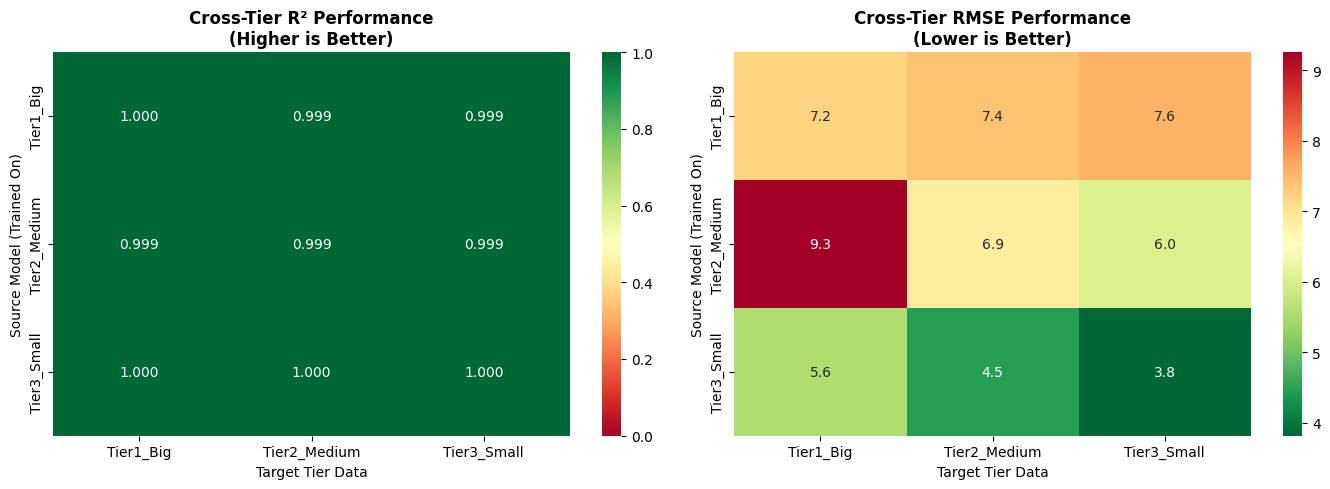

In [17]:
# Visualize Cross-Tier Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Heatmap
sns.heatmap(pivot_r2, annot=True, cmap='RdYlGn', fmt='.3f', ax=axes[0], vmin=0, vmax=1)
axes[0].set_title('Cross-Tier R² Performance\n(Higher is Better)', fontweight='bold')
axes[0].set_xlabel('Target Tier Data')
axes[0].set_ylabel('Source Model (Trained On)')

# RMSE Heatmap
sns.heatmap(pivot_rmse, annot=True, cmap='RdYlGn_r', fmt='.1f', ax=axes[1])
axes[1].set_title('Cross-Tier RMSE Performance\n(Lower is Better)', fontweight='bold')
axes[1].set_xlabel('Target Tier Data')
axes[1].set_ylabel('Source Model (Trained On)')

plt.tight_layout()
plt.savefig('cross_tier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. CROSS-TIER ANALYSIS INSIGHTS

In [23]:
print("="*70)
print("CROSS-TIER GENERALIZATION INSIGHTS")
print("="*70 + "\n")

# Calculate generalization drops
same_tier = cross_df[cross_df['Type'] == 'SAME']
cross_tier = cross_df[cross_df['Type'] == 'CROSS']

avg_same_r2 = same_tier['R2'].mean()
avg_cross_r2 = cross_tier['R2'].mean()
avg_same_rmse = same_tier['RMSE'].mean()
avg_cross_rmse = cross_tier['RMSE'].mean()

print(f"GENERALIZATION SUMMARY:\n")
print(f"Same-Tier Performance (model predicts its own tier):")
print(f"  Average R²: {avg_same_r2:.4f}")
print(f"  Average RMSE: ${avg_same_rmse:.2f}")

print(f"\nCross-Tier Performance (model predicts other tiers):")
print(f"  Average R²: {avg_cross_r2:.4f}")
print(f"  Average RMSE: ${avg_cross_rmse:.2f}")

r2_drop = ((avg_same_r2 - avg_cross_r2) / avg_same_r2) * 100
rmse_increase = ((avg_cross_rmse - avg_same_rmse) / avg_same_rmse) * 100

print(f"\nGENERALIZATION DROP:")
print(f"  R² drops by: {r2_drop:.1f}% when predicting other tiers")
print(f"  RMSE increases by: {rmse_increase:.1f}% when predicting other tiers")

# Best generalizing model
cross_only = cross_df[cross_df['Type'] == 'CROSS'].copy()
best_generalizer = cross_only.groupby('Source_Model')['R2'].mean().idxmax()
print(f"\nBEST GENERALIZING MODEL: {best_generalizer}")
print(f"  This model performs best on unseen market tiers.")

CROSS-TIER GENERALIZATION INSIGHTS

GENERALIZATION SUMMARY:

Same-Tier Performance (model predicts its own tier):
  Average R²: 0.9995
  Average RMSE: $5.97

Cross-Tier Performance (model predicts other tiers):
  Average R²: 0.9993
  Average RMSE: $6.71

GENERALIZATION DROP:
  R² drops by: 0.0% when predicting other tiers
  RMSE increases by: 12.5% when predicting other tiers

BEST GENERALIZING MODEL: Tier3_Small
  This model performs best on unseen market tiers.


## FINAL SUMMARY & CONCLUSIONS

In [20]:
print("="*70)
print("ASSIGNMENT 4 - FINAL SUMMARY")
print("="*70 + "\n")

print("PART 1: INDIVIDUAL CITY PERFORMANCE")
print("-"*50)
print(individual_df[['City', 'Tier', 'XGB_RMSE', 'NN_RMSE', 'Better_Model']].to_string(index=False))

print(f"\nPART 2: COMPOSITE TIER ANALYSIS")
print("-"*50)
print(tier_df[['Tier', 'XGB_RMSE', 'XGB_R2', 'NN_RMSE', 'NN_R2', 'Better_Model']].to_string(index=False))

print(f"\nPART 3: CROSS-TIER NEURAL NETWORK ANALYSIS")
print("-"*50)
print(f"Same-Tier Avg R²: {avg_same_r2:.4f}")
print(f"Cross-Tier Avg R²: {avg_cross_r2:.4f}")
print(f"Generalization Drop: {r2_drop:.1f}%")
print(f"Best Generalizing Model: {best_generalizer}")

print(f"\n{'='*70}")
print("KEY FINDINGS")
print(f"{'='*70}")

overall_xgb_wins = (individual_df['Better_Model'] == 'XGBoost').sum()
overall_nn_wins = len(individual_df) - overall_xgb_wins

print(f"\n1. XGBoost vs Neural Network:")
print(f"   - Individual cities: XGBoost wins {overall_xgb_wins}/{len(individual_df)} cities")
print(f"   - Composite tiers: See table above")

print(f"\n2. Cross-Tier Generalization:")
print(f"   - Models lose ~{r2_drop:.0f}% R² when predicting other market tiers")
print(f"   - {best_generalizer} model generalizes best to unseen markets")

print(f"\n3. Market Tier Insights:")
print(f"   - Big cities show most price variation (hardest to predict)")
print(f"   - Small cities more homogeneous (easier to predict)")
print(f"   - Cross-tier transfer shows market-specific patterns exist")

ASSIGNMENT 4 - FINAL SUMMARY

PART 1: INDIVIDUAL CITY PERFORMANCE
--------------------------------------------------
      City         Tier   XGB_RMSE   NN_RMSE   Better_Model
       NYC    Tier1_Big  48.565245  5.703563 Neural Network
        LA    Tier1_Big  40.328120  8.841134 Neural Network
        SF    Tier1_Big 110.349468  9.594437 Neural Network
   Chicago    Tier1_Big  60.191849  7.530542 Neural Network
    Austin Tier2_Medium  60.843435  6.938188 Neural Network
   Seattle Tier2_Medium  11.782966  8.002324 Neural Network
    Denver Tier2_Medium  11.763427  3.921578 Neural Network
  Portland Tier2_Medium  10.331633  4.863746 Neural Network
 Asheville  Tier3_Small  38.818089  5.589046 Neural Network
Santa_Cruz  Tier3_Small  16.130744 13.806013 Neural Network
     Salem  Tier3_Small   8.959832 11.374814        XGBoost
  Columbus  Tier3_Small  14.631453  4.728177 Neural Network

PART 2: COMPOSITE TIER ANALYSIS
--------------------------------------------------
        Tier  XGB_R